# INFERENCE FINE-TUNNING SEGMENTATION WITH SAM2
Thi notebook is for inferencing the trained fine-tunned model SAM2. Here we will observe images of strawberries wiht the original segmentation in which we will observe prompt points, segmentation using a specific checkpoint (weights of pre-trained models), and the the result of final the finale fine-tuned segmentation.

## 1.  Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


## 2. Navigate to the cloned repository and install SAM2

In [2]:
%cd /content/drive/MyDrive/segment-anything-2
!pwd
!pip install -q -e .

/content/drive/MyDrive/segment-anything-2
/content/drive/MyDrive/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 154.2 kB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


## 2. Import the necessary packages and dependencies

In [3]:
import os
import random
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from pycocotools.coco import COCO

loading annotations into memory...
Done (t=2.81s)
creating index...
index created!


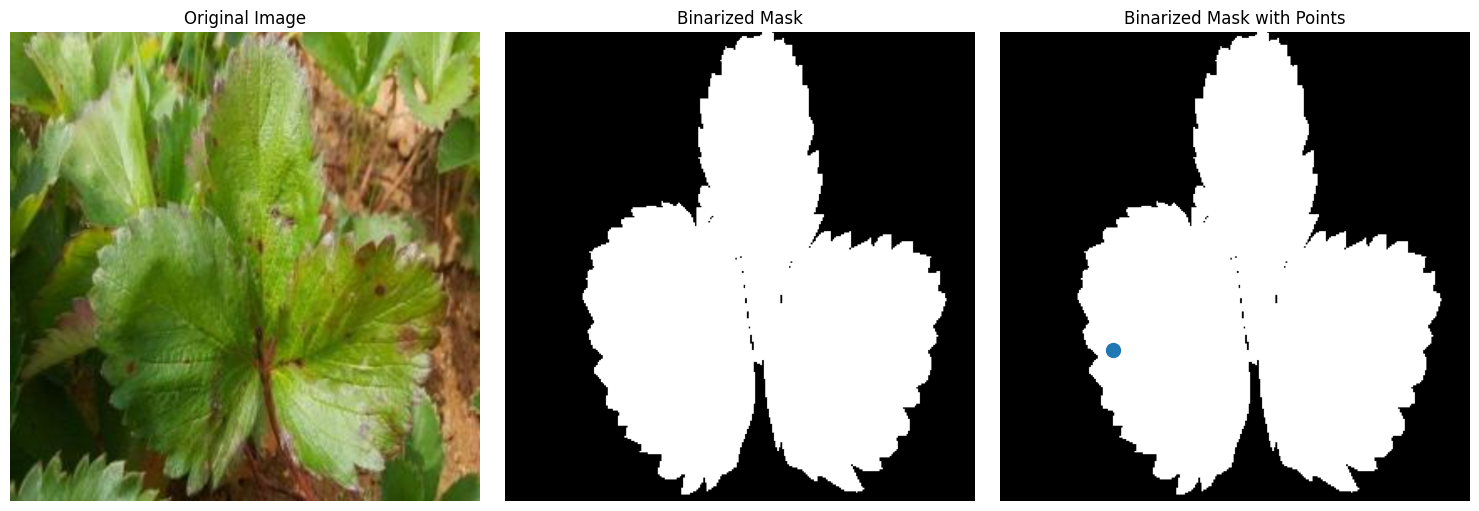

In [4]:
# Path to the prepared data folder
# Define paths to the dataset splits
data_dir = '/content/drive/MyDrive/strawberrySAM2/dataset'
splits = ['train', 'test', 'valid']

def prepare_data(split):
  split_dir = os.path.join(data_dir, split)

  images_dir = split_dir # Images and masks folder are in the same folder
  annotations_path = os.path.join(split_dir, '_annotations.coco.json')


  # Load COCO annotations
  coco = COCO(annotations_path)

  # Get image IDs
  image_ids = coco.getImgIds()

  # Prepare the data list
  data = []

  for image_id in image_ids:

    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(images_dir, image_info['file_name'])

    # Get annotations for the image
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)


    mask_dir = os.path.join(split_dir, 'masks')
    mask_path = os.path.join(mask_dir,  f"{image_info['file_name'].split('.')[0]}_mask.png")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
      raise FileNotFoundError(f"Mask image not found: {mask_path}")

    # Append image and corresponding mask paths
    data.append({
        "image": image_path,
        "annotation": mask_path
    })
  return data
# Prepare data for each split
#train_data = prepare_data('train')
test_data = prepare_data('test')
#valid_data = prepare_data('valid')
# Visualize the data
'''
# Prepare the testing data list (if needed for inference or evaluation later)
test_data = []
for index, row in test_df.iterrows():
   image_name = row['imageid']
   mask_name = row['maskid']

   # Append image and corresponding mask paths
   test_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })
   '''


# Function to read and resize images and masks
def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    # Get full paths
    Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    if Img is None or ann_map is None:
        print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
        return None, None, None, 0

    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []

    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
        for _ in inds:  # Select as many points as there are unique labels
            yx = np.array(coords[np.random.randint(len(coords))])
            points.append([yx[1], yx[0]])

    points = np.array(points)

    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')

        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')

        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order

        # plt.legend()
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)

Img1, masks1, points1, num_masks = read_batch(test_data, visualize_data=True)

In [6]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

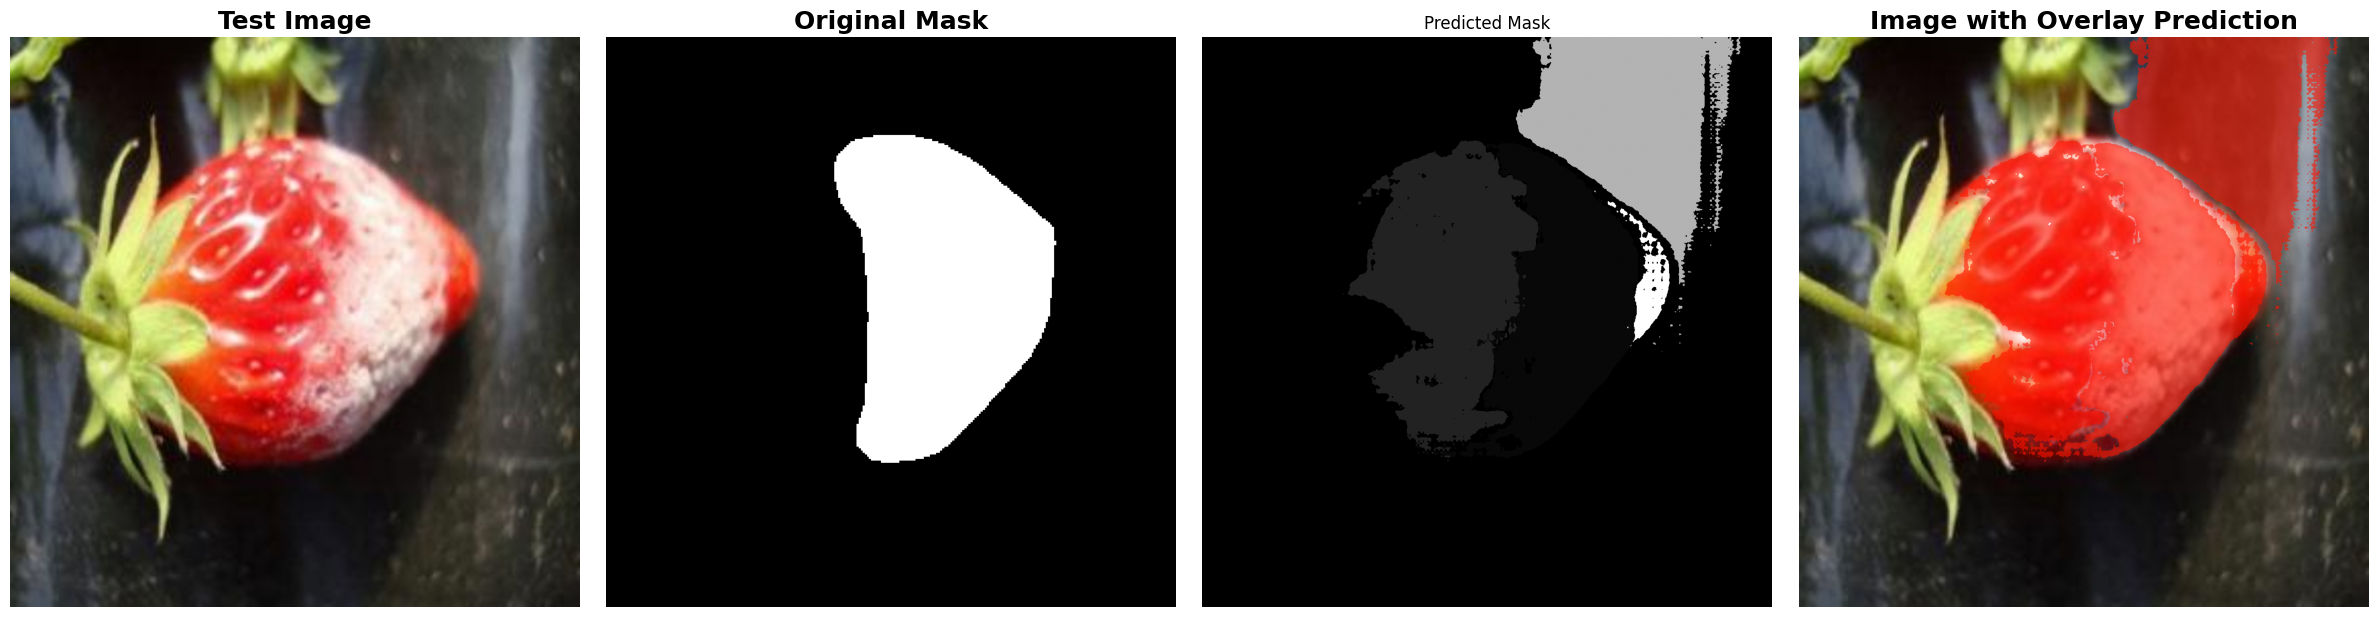

Final layout saved at: /content/drive/MyDrive/strawberrySAM2/fine-tunned-models-sam2/finetuning-sam2-pretrained-sam2-pred_7.png


In [7]:
import random
# Randomly select a test image from the test_data
selected_entry = random.choice(test_data)
# print(selected_entry)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']
# print(mask_path,'mask path')

# Load the selected image and mask
image, target_mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(target_mask, num_samples)

sam2_checkpoint = "/content/drive/MyDrive/segment-anything-2/checkpoints-before-fine-tunning/sam2_hiera_small.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_s.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask


# Define the RGB color and transparency (alpha)
color = (255, 20, 0)  # Green (Modify as needed)
alpha = 0.6  # Transparency factor (0: fully transparent, 1: fully opaque)

# Create an RGB mask with the chosen color
colored_seg_map = np.zeros_like(image, dtype=np.uint8)
colored_seg_map[..., 0] = color[0]  # Red channel
colored_seg_map[..., 1] = color[1]  # Green channel
colored_seg_map[..., 2] = color[2]  # Blue channel

# Create a binary mask where segmentation is present
mask_indices = seg_map > 0

# Blend the original image and the colored mask using transparency
image_with_mask_pt_1 = image.copy()
image_with_mask_pt_1[mask_indices] = (
    (1 - alpha) * image[mask_indices] + alpha * colored_seg_map[mask_indices]
).astype(np.uint8)

# Function to generate a unique output file name with a counter
def get_unique_output_path(base_path, file_name, extension=".png"):
    counter = 1
    output_path = os.path.join(base_path, f"{file_name}_{counter}{extension}")
    # Check for existing files and increment counter
    while os.path.exists(output_path):
        counter += 1
        output_path = os.path.join(base_path, f"{file_name}_{counter}{extension}")
    return output_path

# Define the base path and file name to save results images
base_path = "/content/drive/MyDrive/strawberrySAM2/fine-tunned-models-sam2"  # Current directory or specify the desired folder
file_name = "finetuning-sam2-pretrained-sam2-pred"

# Generate a unique output path
output_path = get_unique_output_path(base_path, file_name)

# Visualization: Create the figure and add subplots
plt.figure(figsize=(24, 6))

plt.subplot(1, 4, 1)
plt.title('Test Image', fontsize=18, fontweight='bold')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Original Mask', fontsize=18, fontweight='bold')
plt.imshow(target_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Predicted Mask')
plt.imshow(seg_map, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Image with Overlay Prediction', fontsize=18, fontweight='bold')
plt.imshow(image_with_mask_pt_1)
plt.axis('off')


# Adjust layout and save the final figure as an image
plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # Save with high resolution (300 DPI)
plt.show()

print(f"Final layout saved at: {output_path}")

<ipython-input-8-14fcf5127ab9>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))


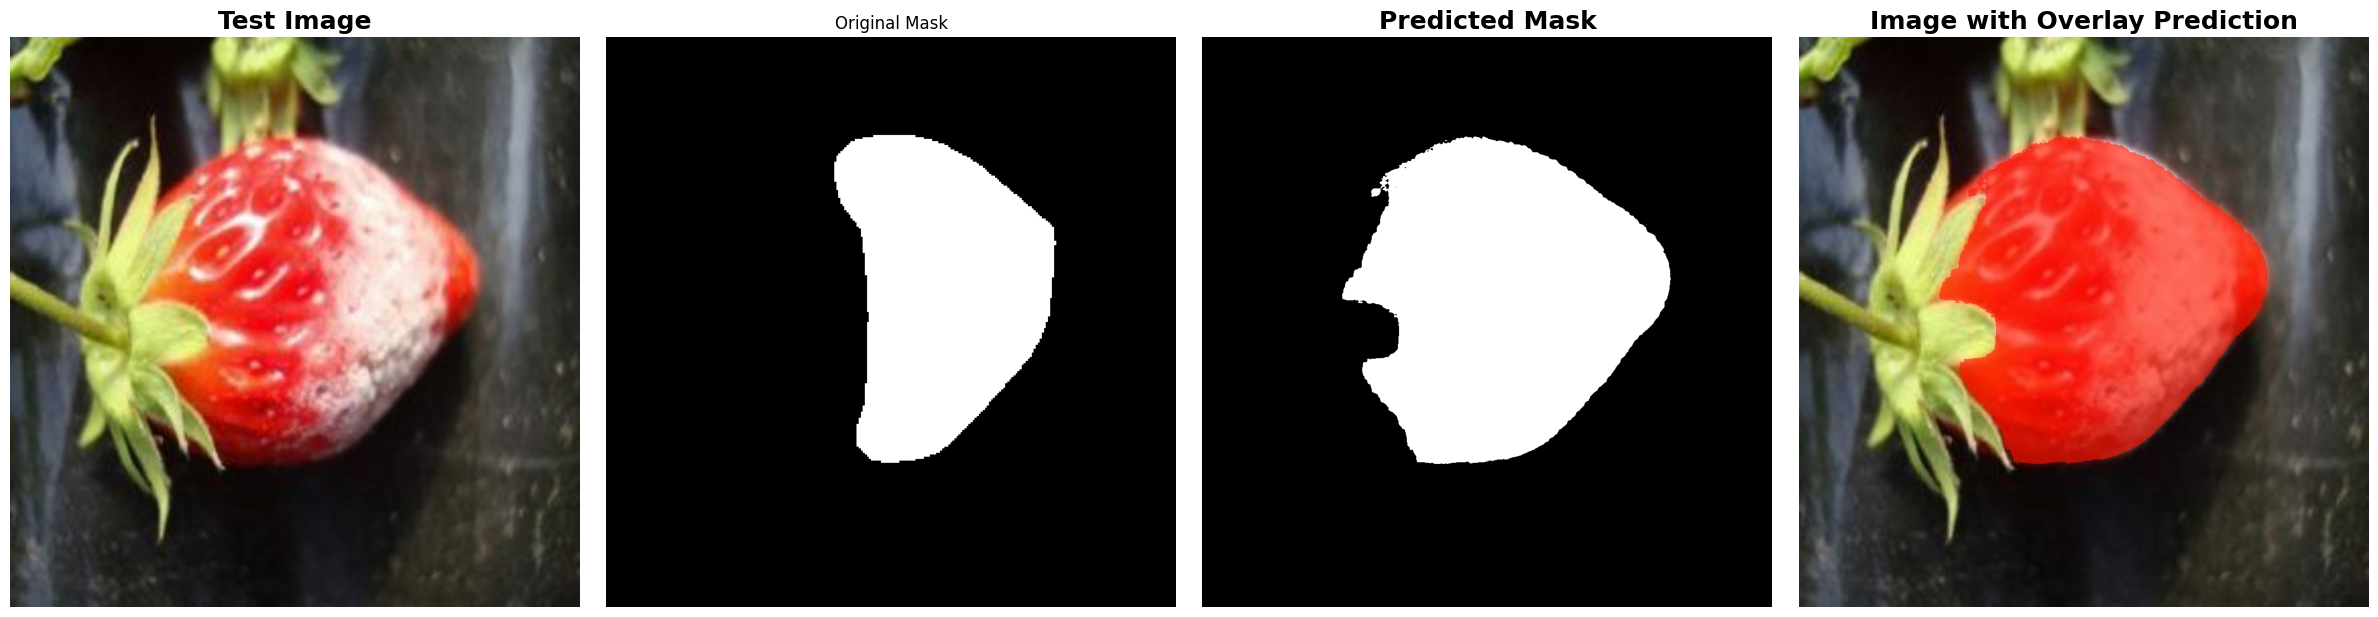

Final layout saved at: ./finetuning-sam2-pretrained-sam2-ft_1.png


In [8]:
# using the same selected entry to compare the the result with the same image
image_path = selected_entry['image']
mask_path = selected_entry['annotation']
# print(mask_path,'mask path')

# Load the selected image and mask
image, target_mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(target_mask, num_samples)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "/content/drive/MyDrive/strawberrySAM2/fine-tunned-models-sam2/fine_tuned_sam2_3000.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Define the RGB color and transparency (alpha)
color = (255, 20, 0)  # Green (Modify as needed)
alpha = 0.6  # Transparency factor (0: fully transparent, 1: fully opaque)

# Create an RGB mask with the chosen color
colored_seg_map = np.zeros_like(image, dtype=np.uint8)
colored_seg_map[..., 0] = color[0]  # Red channel
colored_seg_map[..., 1] = color[1]  # Green channel
colored_seg_map[..., 2] = color[2]  # Blue channel

# Create a binary mask where segmentation is present
mask_indices = seg_map > 0

# Blend the original image and the colored mask using transparency
image_with_mask_ft = image.copy()
image_with_mask_ft[mask_indices] = (
    (1 - alpha) * image[mask_indices] + alpha * colored_seg_map[mask_indices]
).astype(np.uint8)

# Function to generate a unique output file name with a counter
def get_unique_output_path(base_path, file_name, extension=".png"):
    counter = 1
    output_path = os.path.join(base_path, f"{file_name}_{counter}{extension}")
    # Check for existing files and increment counter
    while os.path.exists(output_path):
        counter += 1
        output_path = os.path.join(base_path, f"{file_name}_{counter}{extension}")
    return output_path

# Define the base path and file name
base_path = "."  # Current directory or specify the desired folder
file_name = "finetuning-sam2-pretrained-sam2-ft"

# Generate a unique output path
output_path = get_unique_output_path(base_path, file_name)

# Visualization: Create the figure and add subplots
plt.figure(figsize=(24, 6))

plt.subplot(1, 4, 1)
plt.title('Test Image', fontsize=18, fontweight='bold')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Original Mask')
plt.imshow(target_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Predicted Mask', fontsize=18, fontweight='bold')
plt.imshow(seg_map, cmap='grey')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Image with Overlay Prediction', fontsize=18, fontweight='bold')
plt.imshow(image_with_mask_ft)
plt.axis('off')

# Adjust layout and save the final figure as an image
plt.tight_layout()
plt.savefig(output_path, dpi=300, bbox_inches='tight')  # Save with high resolution (300 DPI)
plt.show()

print(f"Final layout saved at: {output_path}")